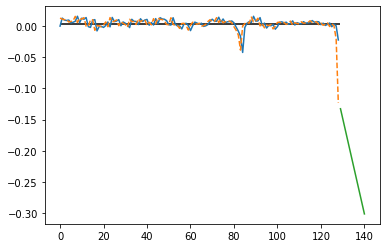

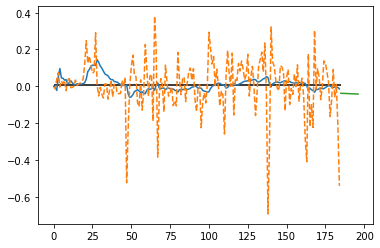

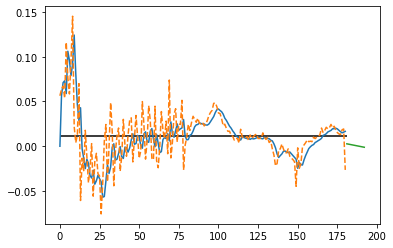

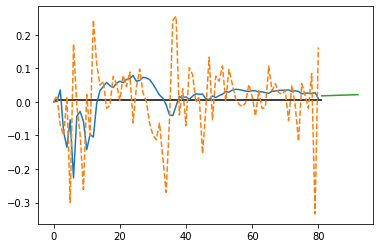

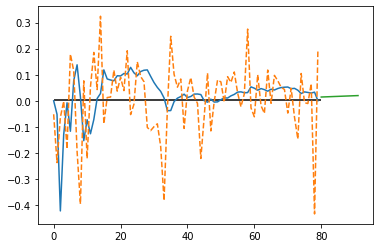

 24%|████████████████▉                                                      | 239180/1000000 [01:05<03:40, 3444.50it/s]

KeyboardInterrupt: 

In [5]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm



class LocalLinearTrend(sm.tsa.statespace.MLEModel):
    def __init__(self, endog):
        # Model order
        k_states = k_posdef = 2

        # Initialize the statespace
        super(LocalLinearTrend, self).__init__(
            endog, k_states=k_states, k_posdef=k_posdef,
            initialization='approximate_diffuse',
            loglikelihood_burn=k_states
        )

        # Initialize the matrices
        self.ssm['design'] = np.array([1, 0])
        self.ssm['transition'] = np.array([[1, 1],
                                       [0, 1]])
        self.ssm['selection'] = np.eye(k_states)

        # Cache some indices
        self._state_cov_idx = ('state_cov',) + np.diag_indices(k_posdef)

    @property
    def param_names(self):
        return ['sigma2.measurement', 'sigma2.level', 'sigma2.trend']

    @property
    def start_params(self):
        return [np.std(self.endog)]*3

    def transform_params(self, unconstrained):
        return unconstrained**2

    def untransform_params(self, constrained):
        return constrained**0.5

    def update(self, params, *args, **kwargs):
        params = super(LocalLinearTrend, self).update(params, *args, **kwargs)

        # Observation covariance
        self.ssm['obs_cov',0,0] = params[0]

        # State covariance
        self.ssm[self._state_cov_idx] = params[1:]

    

def fnDataImport(bDropNA=True):
    """Short summary.

    Parameters
    ----------
    bDropNA : type
        Description of parameter `bDropNA`.

    Returns
    -------
    type
        Description of returned object.

    """

    df = pd.read_excel("D:\QRM_Program\Research_Project\MarketData.xlsx", parse_dates=['Quarter'], index_col='Quarter')
    df.columns = ["GDP", "WTI", "HPI", "SMX", "ASCX"]

    if bDropNA:
        return df.dropna()
    else:
        return df


def fnGBM_calibration(mReturn, iSteps, dt):
    """Short summary.

    Parameters
    ----------
    mReturn : type
        Description of parameter `mReturn`.
    dt : type
        Description of parameter `dt`.

    Returns
    -------
    type
        Description of returned object.

    """
    
    mParams = np.zeros(shape=(iSteps + 2, 5))
    for stock in range(mReturn.shape[1]):
        # Get the time-varying means;
        LLT = LocalLinearTrend(mReturn[:, stock][~np.isnan(mReturn[:, stock])]).fit(disp=False)
        predict = LLT.get_prediction()
        dMu = predict.predicted_mean

        a = np.empty((len(dMu)+12))
        a[:] = np.nan

        forecast = LLT.get_forecast(12)

        a[-12:] = forecast.predicted_mean

        plt.plot(dMu)
        plt.plot(mReturn[:, stock][~np.isnan(mReturn[:, stock])], linestyle='--')
        plt.hlines(np.mean(mReturn[:, stock][~np.isnan(mReturn[:, stock])]), xmin=0, xmax=len(dMu))
        plt.plot(a)
        plt.show()

        # calculate variance
        dVar = np.var(mReturn[:, stock][~np.isnan(mReturn[:, stock])])
        # put parameters in mParams array
        
        mParams[0:12, stock] = forecast.predicted_mean
        mParams[12, stock] = dVar

    return mParams


def fnGBM_simulation(mPrices, mReturn, mCorr, dt, T, iSims):
    
    iSteps = int(T/dt)

    # return calibrated parameters from function based on data given
    mParams = fnGBM_calibration(mReturn, iSteps, dt)  # [dLambda, dMu, dSigma]
    vMu = mParams[0:iSteps,:]
    vSigma = mParams[iSteps , :]
    #vMu = mParams[0, :]
    #vSigma = mParams[1, :]

    # get the number of assets
    iAssets = mReturn.shape[1]

    # calculate amount of steps in simulations
    iSteps = int(T/dt)

    # pre-allocate the output
    mS = np.zeros([iSteps + 1, iSims, iAssets])
    mS[0, :, :] = mPrices[-1, :]
    # generate correlated random sequences and paths
    for sim in tqdm(range(iSims)):
        # generate correlated random sequence
        mDW = np.random.multivariate_normal(np.zeros(iAssets), mCorr, iSteps + 1)
        for i in range(1, iSteps+1):
            mS[i, sim, :] = mS[i-1, sim, :] * \
                np.exp((vMu[i-1]*dt) + (np.sqrt(vSigma) * np.sqrt(dt)*mDW[i]))
    return mS


def Main():

    # load all data and also changes
    dfFull = fnDataImport(bDropNA=False)

    # calculate log differences for additivity later on
    dfReturnFull = np.log(dfFull).diff()

    # clip extreme 1% and 99% values to better approximate "real-world"
    dfReturnFullClipped = dfReturnFull.copy()
    # dfReturnFullClipped['GDP'] = dfReturnFull['GDP'].clip(lower=dfReturnFull['GDP'].quantile(
    #     0.00), upper=dfReturnFull['GDP'].quantile(1))
    # plt.hist(dfReturnFullClipped['GDP'])

    # calculate correlation matrix and changes matrix
    mCorr = dfReturnFull.corr().values
    mReturn = dfReturnFullClipped.values
    mPrices = dfFull.values

    # magic numbers
    T = 3  # simulate 3 years ahead
    dt = 1/4  # each step is one quarter
    iSims = 1000  # simulate iSim scenarios

    mS = fnGBM_simulation(mPrices, mReturn, mCorr, dt, T, iSims)

    # get historical 3 year changes/ 12 quarters
    mHistorical = dfFull.pct_change(12).values
    mSimulatedDistributions = np.zeros((iSims, mPrices.shape[1]))
    for i in range(mPrices.shape[1]):
        mSimulatedDistributions[:, i] = ((mS[-1, :, i] - mS[0, :, i]) / mS[0, :, i])
    np.savetxt("sims/GBM.csv", mSimulatedDistributions, delimiter=",", fmt='%.6e')

    fig = plt.figure(figsize=(12, 8))
    fig.suptitle('Simulating %i paths for %i assets' % (iSims, len(dfFull.columns)))
    columns = 2
    rows = 3
    list_assets = ["GDP", "WTI", "HPI", "SMX", "ASCX"]
    for i in range(1, 6):
        fig.add_subplot(rows, columns, i)
        plt.hist([mSimulatedDistributions[:, i-1], mHistorical[:, i-1]], color=['g', 'r'],
                 label=['Generated 3Y-change Asset '+list_assets[i-1],
                        'Historical 3Y-change Asset '+list_assets[i-1]], bins=40, density=True)
        plt.legend()
    plt.show()


if __name__ == '__main__':
    Main()
